In [1]:
# Importing neccassary torch libraries
import torch
import torch.nn.functional as F
import torch.nn as NN
import torch.utils.data
import torch.optim as optim

# numpy for numerical operations and matplotlib for plotting the image
import matplotlib.pyplot as plt
import numpy as np

# libraries for handling datasets, image transformations, and visualizing data.
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
class RBM(NN.Module): # Here i am defining RBM class from nn.Module, which the base class for all neural network modules in PyTorch

    def __init__(self, num_visible=784, num_hidden=128, k=1):
        # The constructor for the RBM class. Initializing my class specified number of visible
        # units num_visible = 784 (taking into considiration MNIST dataset consisting of 28x28 pixels)
        # hidden units num_hidden = 200 (ensuring its fair complexity)
        # Gibbs sampling steps (k) = 1

        super(RBM, self).__init__()
        self.visible = NN.Parameter(torch.randn(1, num_visible))
        self.hidden = NN.Parameter(torch.randn(1, num_hidden))
        self.W= NN.Parameter(torch.randn(num_hidden, num_visible))
        self.k = k

    def visible_to_hidden(self, visible):
        # Defining a method to sample hidden units given visible units using the conditional probability

        p = torch.sigmoid(F.linear(visible, self.W, self.hidden))
        return p.bernoulli()

    def hidden_to_visible(self, hidden):
        # Defining a method to sample visible units given hidden units using the conditional probability

        p = torch.sigmoid(F.linear(hidden, self.W.t(), self.visible))
        return p.bernoulli()

    def free_energy(self, visible):
        #Free energy function. A method to compute the free energy of a visible state v,
        # which is essential for computing gradients during training. Formula was taken from the third-party articles&books

        v_term = torch.matmul(visible, self.visible.t())
        w_x_h = F.linear(visible, self.W, self.hidden)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, visible):
       # method which computes the visible states after k steps of Gibbs sampling.

        hidden = self.visible_to_hidden(visible)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(hidden)
            hidden = self.visible_to_hidden(v_gibb)
        return visible, v_gibb

In [10]:
def mse_error(original, reconstructed):
    return ((original - reconstructed) ** 2).mean()

# Defining my train function which takes the model (RBM), trainer_loader (data loader for training data)
# num_epochs (number of epochs to train for, default = 1) and and lr (learning rate, default = 0.01)

def train(model, train_loader, n_epochs=1, learning_rate=0.01):
    train_op = optim.Adam(model.parameters(), learning_rate)
    model.train()

    # A loop specified number of epochs, updating weights using gradient descent
    # to minimize the difference in free energy between original and reconstructed images, and prints the average loss for each epoch

    for epoch in range(n_epochs):
        loss_ = []
        mse_errors = []
        for _, (data, _) in enumerate(train_loader):
            data = data.view(-1, 784)
            v, v_gibbs = model(data)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())

            # Calculate and store the MSE error for this batch
            mse = mse_error(data, v_gibbs)
            mse_errors.append(mse.item())

            train_op.zero_grad()
            loss.backward()
            train_op.step()

        # Reporting the average loss and average MSE for the epoch
        avg_loss = np.mean(loss_)
        avg_mse = np.mean(mse_errors)
        print(f'Epoch #{epoch + 1} Avg MSE: {avg_mse:.2f}')

    return model

In [11]:
# Addinitional function to save and show image once executed
def show_and_save(img, file_name):

    pic = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.jpg" % file_name

    plt.imshow(pic, cmap='gray')
    plt.imsave(f, pic)

In [12]:
# HYPER-PARAMETERS (experimented with various hyperparameters below)
batch_size = 40
num_epochs = 5
lr = 0.01
n_hid = 200
n_vis = 784

In [13]:
model = RBM(num_visible=n_vis, num_hidden=n_hid, k=1)

In [14]:
# This code initializes a DataLoader for the MNIST dataset, downloading it if necessary,
# onverting images to tensors, and organizing them into batches of a specified size for training. Saving results in ./ouput file
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=True, download=True,
                   transform=transforms.Compose([ transforms.ToTensor() ])),
    batch_size=batch_size
)

In [ ]:
# Train the model with the given hyperparameters
model = train(model, train_loader, n_epochs=num_epochs, learning_rate=lr)

In [16]:
# Fetch a batch of images and perform Gibbs sampling to generate new samples
images = next(iter(train_loader))[0]
v, v_gibbs = model(images.view(-1, 784))

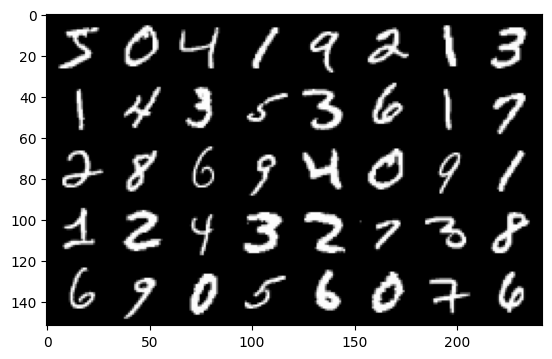

In [17]:
# Saving and showing original image
show_and_save(make_grid(v.view(batch_size, 1, 28, 28).data), 'output/original_images')

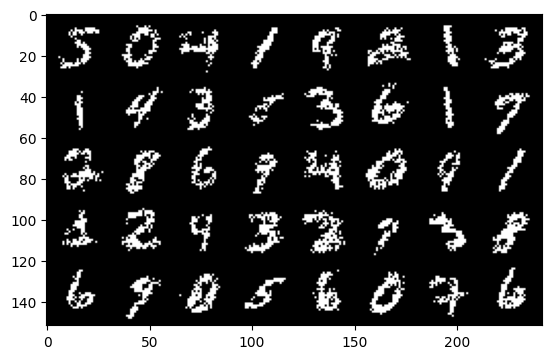

In [18]:
# Saving and showing generated by RBM
show_and_save(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), 'output/generated_image')